# FAKE REVIEW DETECTION USING MACHINE LEARNING TECNIQUES

Variable Decription:
1. id: identification
2. ex_id: index
3. id_user: user's account number
4. prod_id: restaurant collected from Yelp
5. rating: 1-Verry Bad, 2-Bad, 3-Average, 4-Good, 5-Verry Good
6. label: 0-True, 1-Fake
7. date: date of user posted their reviews
8. review: content of user's reviews


## Data Collection

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re;
import pickle
import os

In [2]:
train_path = r"....\Project\Final\train.csv" #Change the path before reading csv
train = pd.read_csv(train_path)
 # drop columns we don't need

In [3]:
train

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...
...,...,...,...,...,...,...,...
250869,358950,14671,349,5.0,0,2014-02-08,Made a reservation for an early dinner Saturda...
250870,358951,3356,349,5.0,0,2014-02-07,"Emily is like Franny's Marco, but with warmth ..."
250871,358953,116424,349,5.0,0,2014-01-31,Can't say enough good things about this place....
250872,358954,161147,349,5.0,0,2014-01-30,"Had a great dinner here- fantastic pizza, the ..."


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250874 entries, 0 to 250873
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ex_id    250874 non-null  int64  
 1   user_id  250874 non-null  int64  
 2   prod_id  250874 non-null  int64  
 3   rating   250874 non-null  float64
 4   label    250874 non-null  int64  
 5   date     250874 non-null  object 
 6   review   250874 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 13.4+ MB


In [5]:
train.groupby(['label']).count()

,ex_id,user_id,prod_id,rating,date,review
label,,,,,,
0,225055,225055,225055,225055,225055,225055
1,25819,25819,25819,25819,25819,25819


##### Adding feature in existing dataset of average rating of the product

In [7]:
average_rating_per_product = train.groupby('prod_id')['rating'].mean()
average_rating_per_product = average_rating_per_product.to_frame()
average_rating_per_product.reset_index(level=0, inplace=True)
average_rating_per_product = average_rating_per_product.rename(columns={'rating':'Avg_Prod_Rating'})
average_rating_per_product.head()

,prod_id,Avg_Prod_Rating
0,0,3.954839
1,1,4.361257
2,2,3.830508
3,3,4.102564
4,4,4.058824


In [8]:
train= train.merge(average_rating_per_product, left_on='prod_id', right_on='prod_id')

In [9]:
train.head(1)

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839


##### Lets add feature of average rating that the user gives for comparison

In [11]:
average_rating_per_user = train.groupby('user_id')['rating'].mean()
average_rating_per_user = average_rating_per_user.to_frame()
average_rating_per_user.reset_index(level=0, inplace=True)
average_rating_per_user = average_rating_per_user.rename(columns={'rating':'Avg_user_rating'})
average_rating_per_user.head()

,user_id,Avg_user_rating
0,923,4.500000
1,924,3.000000
2,925,4.000000
3,926,4.000000
4,927,4.333333


In [12]:
train = train.merge(average_rating_per_user, left_on='user_id', right_on='user_id')

In [13]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.5
1,5992,923,19,5.0,1,2014-01-14,The restaurant is on the ground floor of a typ...,4.067511,4.5
2,12853,923,40,4.0,1,2014-05-30,Really nice mousaka and lovely décor inside. A...,4.303390,4.5
3,29654,923,79,3.0,1,2014-03-30,We ate at the Blue Ribbon with colleagues. The...,4.295019,4.5
4,30833,923,81,4.0,1,2014-09-28,I loved the antibiotic- and hormone-free chick...,4.196078,4.5


In [14]:
train.describe()

,ex_id,user_id,prod_id,rating,label,Avg_Prod_Rating,Avg_user_rating
count,250874.000000,250874.000000,250874.000000,250874.000000,250874.000000,250874.000000,250874.000000
mean,179413.488815,53970.730446,459.778211,4.023717,0.102916,4.023717,4.023717
std,103640.791253,45803.665418,259.854178,1.056995,0.303850,0.220664,0.843959
min,0.000000,923.000000,0.000000,1.000000,0.000000,2.970588,1.000000
25%,89526.500000,13820.000000,247.000000,4.000000,0.000000,3.876404,3.727273
50%,179345.500000,40485.500000,468.000000,4.000000,0.000000,3.990063,4.000000
75%,269196.750000,87298.000000,672.000000,5.000000,0.000000,4.164234,4.600000
max,358956.000000,161147.000000,922.000000,5.000000,1.000000,5.000000,5.000000


#### Extracting Review length from dataset

In [16]:
train['Review_Len']= train['review'].apply(len)

In [17]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.5,215
1,5992,923,19,5.0,1,2014-01-14,The restaurant is on the ground floor of a typ...,4.067511,4.5,513
2,12853,923,40,4.0,1,2014-05-30,Really nice mousaka and lovely décor inside. A...,4.303390,4.5,231
3,29654,923,79,3.0,1,2014-03-30,We ate at the Blue Ribbon with colleagues. The...,4.295019,4.5,255
4,30833,923,81,4.0,1,2014-09-28,I loved the antibiotic- and hormone-free chick...,4.196078,4.5,162


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3C2583080>,
      dtype=object)

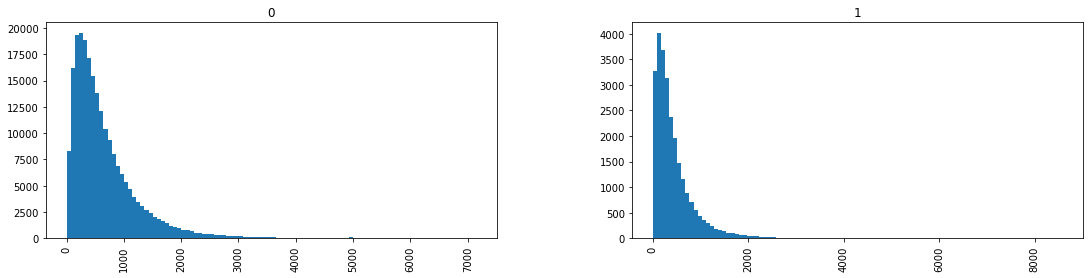

In [18]:
train.hist(column='Review_Len', by = 'label', bins=100, figsize=(18,4))

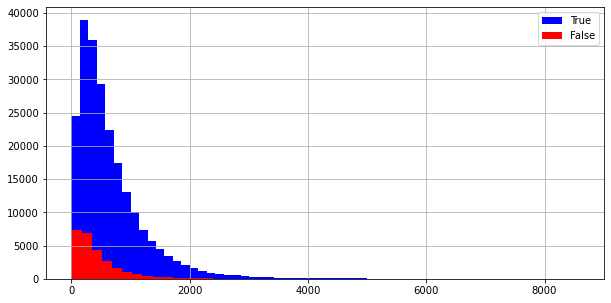

In [19]:
plt.figure(figsize=[10,5])
train[train['label'] == 0]['Review_Len'].hist(bins=50, label='True', color='blue')
train[train['label'] == 1]['Review_Len'].hist(bins=50, label='False', color='red')
plt.legend()

C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


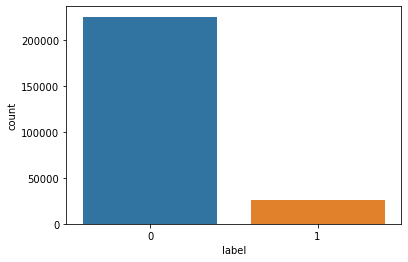

In [20]:
sns.countplot(train['label'])

We can see that our data is highly imbalanced, we need to understand how to handle unbalanced data

In [62]:
train.groupby('label')['Review_Len'].mean()

label
0    657.372571
1    443.433053
Name: Review_Len, dtype: float64

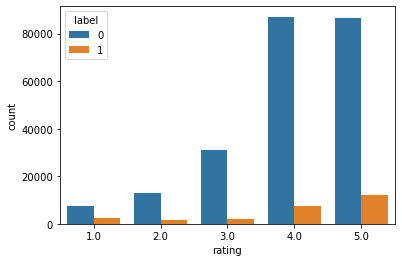

In [63]:
sns.countplot(data=train, x='rating', hue='label')

In [ ]:
Word Cloud for Fake Reviews

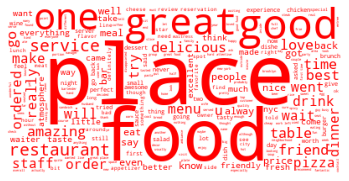

In [64]:
word_string=" ".join(train[train['label']==1]['review'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300, color_func=(lambda *args, **kwargs: (255,0,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
Word Cloud for True Reviews

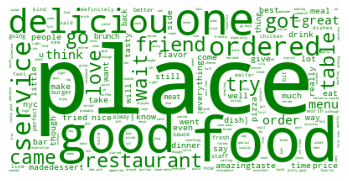

<Figure size 864x288 with 0 Axes>

In [65]:
word_string=" ".join(train[train['label']==0]['review'].str.lower())
wordcloud_false = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300, color_func=(lambda *args, **kwargs: (0,128,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud_false)
plt.axis('off')
plt.figure(figsize=[12,4])
plt.show()

In [ ]:
Extracting total reviews for a user to identify his review pattern

In [67]:
user_total_reviews=train.groupby('user_id').count()['label']

In [68]:
user_total_reviews = user_total_reviews.to_frame()
user_total_reviews.reset_index(level=0, inplace=True)
user_total_reviews =  user_total_reviews.rename(columns={'label':'user_total_reviews'})
user_total_reviews.head()

,user_id,user_total_reviews
0,923,26
1,924,1
2,925,2
3,926,1
4,927,3


In [69]:
train = train.merge(user_total_reviews,  left_on='user_id', right_on='user_id')

In [70]:
train

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.5,215,26
1,5992,923,19,5.0,1,2014-01-14,The restaurant is on the ground floor of a typ...,4.067511,4.5,513,26
2,12853,923,40,4.0,1,2014-05-30,Really nice mousaka and lovely décor inside. A...,4.303390,4.5,231,26
3,29654,923,79,3.0,1,2014-03-30,We ate at the Blue Ribbon with colleagues. The...,4.295019,4.5,255,26
4,30833,923,81,4.0,1,2014-09-28,I loved the antibiotic- and hormone-free chick...,4.196078,4.5,162,26
...,...,...,...,...,...,...,...,...,...,...,...
250869,358945,49686,349,3.0,0,2014-02-13,I dislike being the one to not rate full stars...,4.185185,3.0,444,1
250870,358947,161144,349,5.0,0,2014-02-11,The food was perfect. The wine was perfect. Th...,4.185185,5.0,411,1
250871,358949,161145,349,5.0,0,2014-02-09,Came here for Sunday brunch. Everything we tas...,4.185185,5.0,252,1
250872,358953,116424,349,5.0,0,2014-01-31,Can't say enough good things about this place....,4.185185,5.0,475,1


##### Saving the processed data onto csv

In [71]:
path= r"....\Project\Final" #Change the path before saving to csv
import os
train.to_csv(os.path.join(path,r'FinalData.csv'))

In [21]:
train_path = r"....\Project\Final\FinalData.csv"  #Change the path before reading csv
train = pd.read_csv(train_path)
train = train.sort_values(by=['ex_id'])
train = train.drop(columns=['Unnamed: 0'])

In [22]:
train

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.500000,215,26
26,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,3.954839,3.000000,269,1
27,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,3.954839,4.000000,178,2
29,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,3.954839,4.000000,491,1
30,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,3.954839,4.333333,596,3
...,...,...,...,...,...,...,...,...,...,...,...
55168,358950,14671,349,5.0,0,2014-02-08,Made a reservation for an early dinner Saturda...,4.185185,4.333333,1418,3
11834,358951,3356,349,5.0,0,2014-02-07,"Emily is like Franny's Marco, but with warmth ...",4.185185,4.100000,763,60
250872,358953,116424,349,5.0,0,2014-01-31,Can't say enough good things about this place....,4.185185,5.000000,475,1
250873,358954,161147,349,5.0,0,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",4.185185,5.000000,268,1


### Data cleaning & Corpus

In [194]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from itertools import chain
from collections import Counter 

In [195]:
corpus = np.array(train['review']) #convert from Dataframe to array
corpus = corpus.ravel()#used to convert from multi-dimensional array to 1 dimension

In [196]:
#Preprocessing Text Corpus
wpt=nltk.WordPunctTokenizer()

In [197]:
stop_words = set(stopwords.words('english')) 

In [198]:
def normalize_docuement (doc):
    #lowercase and remove special characters\whitespace
    doc=re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I ignore case sensitive, ASCII-only matching
    doc=doc.lower()
    doc=doc.strip()
    #tokenize document
    tokens=wpt.tokenize(doc)
    #filter stopwords out of document
    filtered_tokens=[token for token in tokens if token not in stop_words]
    #re-create documenr from filtered tokens
    doc=' '.join(filtered_tokens)
    return doc

In [199]:
normalize_corpus=np.vectorize(normalize_docuement)
norm_corpus=normalize_corpus(corpus)

In [200]:
train['corpus'] = norm_corpus.tolist()

In [201]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.500000,215,26,food snack selection popular greek dishes appe...
26,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,3.954839,3.000000,269,1,little place soho wonderful lamb sandwich glas...
27,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,3.954839,4.000000,178,2,ordered lunch snack last friday time nothing m...
29,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,3.954839,4.000000,491,1,beautiful quaint little restaurant pretty stre...
30,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,3.954839,4.333333,596,3,snack great place casual sit lunch especially ...


### Sentiment Analysis

In [203]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [204]:
analyzer = SentimentIntensityAnalyzer()

In [205]:
train['neg'] = train['corpus'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
train['neu'] = train['corpus'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
train['pos'] = train['corpus'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
train['compound'] = train['corpus'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [206]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,neg,neu,pos,compound
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.500000,215,26,food snack selection popular greek dishes appe...,0.061,0.693,0.247,0.6486
26,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,3.954839,3.000000,269,1,little place soho wonderful lamb sandwich glas...,0.159,0.602,0.239,0.5446
27,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,3.954839,4.000000,178,2,ordered lunch snack last friday time nothing m...,0.140,0.639,0.221,0.2249
29,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,3.954839,4.000000,491,1,beautiful quaint little restaurant pretty stre...,0.034,0.545,0.421,0.9772
30,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,3.954839,4.333333,596,3,snack great place casual sit lunch especially ...,0.000,0.669,0.331,0.9756


Function to help us extract count of regex patterns from review text

In [207]:
def count_regex(pattern, row):
    return len(re.findall(pattern, row))

Extracting count of capital words

In [208]:
count_capital_words = train['review'].apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', x))
train['number_Cap_Words'] = count_capital_words.to_frame();

In [209]:
train.head(1)

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,neg,neu,pos,compound,number_Cap_Words
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.5,215,26,food snack selection popular greek dishes appe...,0.061,0.693,0.247,0.6486,0


### Extracting count of digits in review

In [211]:
count_digit_words = train['review'].apply(lambda x: count_regex(r'\b[0-9]{2,}\b', x))
train['number_digit_Words'] = count_digit_words.to_frame();

In [212]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,neg,neu,pos,compound,number_Cap_Words,number_digit_Words
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.500000,215,26,food snack selection popular greek dishes appe...,0.061,0.693,0.247,0.6486,0,0
26,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,3.954839,3.000000,269,1,little place soho wonderful lamb sandwich glas...,0.159,0.602,0.239,0.5446,0,0
27,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,3.954839,4.000000,178,2,ordered lunch snack last friday time nothing m...,0.140,0.639,0.221,0.2249,0,1
29,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,3.954839,4.000000,491,1,beautiful quaint little restaurant pretty stre...,0.034,0.545,0.421,0.9772,0,0
30,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,3.954839,4.333333,596,3,snack great place casual sit lunch especially ...,0.000,0.669,0.331,0.9756,0,0


#### Function to count noun phrases in review text

In [214]:
#! pip install -U git+https://github.com/sloria/TextBlob.git@dev
from textblob import TextBlob

In [215]:
def identify_noun_count(sentence):
    blob = TextBlob(sentence)
    return len(blob.noun_phrases)

In [216]:
#Extracting noun count from our review text
train['noun_count'] = train['review'].apply(identify_noun_count)

In [217]:
train

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,neg,neu,pos,compound,number_Cap_Words,number_digit_Words,noun_count
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.500000,215,26,food snack selection popular greek dishes appe...,0.061,0.693,0.247,0.6486,0,0,3
26,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,3.954839,3.000000,269,1,little place soho wonderful lamb sandwich glas...,0.159,0.602,0.239,0.5446,0,0,5
27,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,3.954839,4.000000,178,2,ordered lunch snack last friday time nothing m...,0.140,0.639,0.221,0.2249,0,1,2
29,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,3.954839,4.000000,491,1,beautiful quaint little restaurant pretty stre...,0.034,0.545,0.421,0.9772,0,0,6
30,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,3.954839,4.333333,596,3,snack great place casual sit lunch especially ...,0.000,0.669,0.331,0.9756,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55168,358950,14671,349,5.0,0,2014-02-08,Made a reservation for an early dinner Saturda...,4.185185,4.333333,1418,3,made reservation early dinner saturday night l...,0.000,0.525,0.475,0.9980,0,0,32
11834,358951,3356,349,5.0,0,2014-02-07,"Emily is like Franny's Marco, but with warmth ...",4.185185,4.100000,763,60,emily like frannys marco warmth value emily ch...,0.000,0.611,0.389,0.9901,0,1,18
250872,358953,116424,349,5.0,0,2014-01-31,Can't say enough good things about this place....,4.185185,5.000000,475,1,cant say enough good things place stopped last...,0.061,0.484,0.455,0.9829,0,0,9
250873,358954,161147,349,5.0,0,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",4.185185,5.000000,268,1,great dinner fantastic pizza smore pizza desse...,0.000,0.467,0.533,0.9750,0,0,4


In [ ]:
path= r"C:\Users\13152\Desktop\KAJJU\GBA 6410\Project\Final" #Change the path
import os
train.to_csv(os.path.join(path,r'Final_Processed_data.csv'))

### Reading Final Dataset After Pre-Processing

In [23]:
import os
import numpy as np # linear algebra
import pandas as pd

In [24]:
data = pd.read_csv(r"....\Project\Final\Final_Processed_data.csv")

In [25]:
data = data.drop(columns=['Unnamed: 0'])
data

,ex_id,user_id,prod_id,rating,label,date,review,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,neg,neu,pos,compound,number_Cap_Words,number_digit_Words,noun_count
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,3.954839,4.500000,215,26,food snack selection popular greek dishes appe...,0.061,0.693,0.247,0.6486,0,0,3
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,3.954839,3.000000,269,1,little place soho wonderful lamb sandwich glas...,0.159,0.602,0.239,0.5446,0,0,5
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,3.954839,4.000000,178,2,ordered lunch snack last friday time nothing m...,0.140,0.639,0.221,0.2249,0,1,2
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,3.954839,4.000000,491,1,beautiful quaint little restaurant pretty stre...,0.034,0.545,0.421,0.9772,0,0,6
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,3.954839,4.333333,596,3,snack great place casual sit lunch especially ...,0.000,0.669,0.331,0.9756,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250869,358950,14671,349,5.0,0,2014-02-08,Made a reservation for an early dinner Saturda...,4.185185,4.333333,1418,3,made reservation early dinner saturday night l...,0.000,0.525,0.475,0.9980,0,0,32
250870,358951,3356,349,5.0,0,2014-02-07,"Emily is like Franny's Marco, but with warmth ...",4.185185,4.100000,763,60,emily like frannys marco warmth value emily ch...,0.000,0.611,0.389,0.9901,0,1,18
250871,358953,116424,349,5.0,0,2014-01-31,Can't say enough good things about this place....,4.185185,5.000000,475,1,cant say enough good things place stopped last...,0.061,0.484,0.455,0.9829,0,0,9
250872,358954,161147,349,5.0,0,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",4.185185,5.000000,268,1,great dinner fantastic pizza smore pizza desse...,0.000,0.467,0.533,0.9750,0,0,4


In [26]:
data.dropna(axis=0, inplace=True)

#### Identifying the most common words for Fake and True reviews

In [99]:
positive = data[data['label']== 0]
fake = data[data['label'] == 1]
true_word_list = []

In [100]:
for i in range(0,positive['corpus'].count()):
    true_word_temp = positive['corpus'].iloc[i].split()
    true_word_list.append(true_word_temp)
from itertools import chain
list1 = list(chain.from_iterable(true_word_list))
from collections import Counter 
true_mc = Counter(list1).most_common()
 
fake_word_list= fake['corpus'].str.split(expand=True).stack()
from collections import Counter 
fake_mc = Counter(fake_word_list).most_common() 

In [101]:
for i in range(0,positive['corpus'].count()):
    true_word_temp = positive['corpus'].iloc[i].split()
    true_word_list.append(true_word_temp)
from itertools import chain
list1 = list(chain.from_iterable(true_word_list))
from collections import Counter
true_mc = Counter(list1).most_common()

fake_word_list= fake['corpus'].str.split(expand=True).stack()
from collections import Counter
fake_mc = Counter(fake_word_list).most_common()

In [102]:
for i in range(0,positive['corpus'].count()):
    true_word_temp = positive['corpus'].iloc[i].split()
    true_word_list.append(true_word_temp)
from itertools import chain
list1 = list(chain.from_iterable(true_word_list))
from collections import Counter
true_mc = Counter(list1).most_common()
 
fake = data[data['label'] == 1]
fake_word_list= fake['corpus'].str.split(expand=True).stack()
from collections import Counter
fake_mc = Counter(fake_word_list).most_common()
fake_mc
 
df_true = pd.DataFrame(true_mc)
df_false = pd.DataFrame(fake_mc)
df_false1 = df_false[0:23]
df_true1 = df_true[0:23]
df_common = list(set(df_true1.iloc[:,0]) & set(df_false1.iloc[:,0]))
df_common

['time',
 'like',
 'really',
 'dont',
 'best',
 'place',
 'food',
 'also',
 'restaurant',
 'get',
 'delicious',
 'back',
 'one',
 'go',
 'us',
 'good',
 'great',
 'service',
 'would',
 'wait']

# Logistic Regression

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

#### Split original data into train and test

In [110]:
sentences_train, sentences_test, y_train, y_test = train_test_split(data.drop(columns=['label']), data['label'], test_size=0.2, random_state=101)

In [111]:
sentences_train.shape

(200672, 18)

In [112]:
sentences_test.shape

(50168, 18)

#### Using Count Vectorizer only on corpus column of train data set to generate features also using ngram = 3 and removing stop words (df_common)

In [113]:
vectorizer = CountVectorizer(stop_words= df_common, ngram_range=(2,3), max_features= 15000)
vectorizer.fit(sentences_train.corpus)

CountVectorizer(max_features=15000, ngram_range=(2, 3),
                stop_words=['time', 'like', 'really', 'dont', 'best', 'place',
                            'food', 'also', 'restaurant', 'get', 'delicious',
                            'back', 'one', 'go', 'us', 'good', 'great',
                            'service', 'would', 'wait'])

Transforming text values to numeric using above vectorizer on train and test dataset

In [115]:
x_train = vectorizer.transform(sentences_train.corpus)
x_test  = vectorizer.transform(sentences_test.corpus)

Merging vectorised features with our extracted features using scipy library

In [116]:
import scipy as sp

In [117]:
final_train = sp.sparse.hstack((x_train,sentences_train[['rating','Avg_Prod_Rating','Avg_user_rating', 'Review_Len','user_total_reviews','compound','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')
final_test = sp.sparse.hstack((x_test,sentences_test[['rating','Avg_Prod_Rating','Avg_user_rating', 'Review_Len','user_total_reviews','compound','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')

### Using Random UnderSampling to handle imbalance data

In [121]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(final_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 20734), (1, 20734)]


Model to be fit

In [124]:
#ML Model
classifier = LogisticRegression()
classifier.fit(X_resampled,  y_resampled)
score = classifier.score(final_test, y_test)

print("Accuracy:", score)

Accuracy: 0.55224445861904


C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy + Report + Confusion Matrix

In [125]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = classifier.predict(final_test)
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.97      0.52      0.68     45087
           1       0.17      0.85      0.28      5081

    accuracy                           0.55     50168
   macro avg       0.57      0.68      0.48     50168
weighted avg       0.89      0.55      0.64     50168



array([[23411, 21676],
       [  787,  4294]], dtype=int64)

### Using Random OverSampling to handle imbalance data

In [126]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 179938), (1, 179938)]


Model to be fit

In [127]:
classifier = LogisticRegression()
classifier.fit(X_resampled, y_resampled)
score = classifier.score(x_test, y_test)

print("Accuracy:", score) 

Accuracy: 0.6345479189921862


C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy + Report + Confusion Matrix

In [128]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.93      0.64      0.76     45087
           1       0.15      0.58      0.24      5081

    accuracy                           0.63     50168
   macro avg       0.54      0.61      0.50     50168
weighted avg       0.85      0.63      0.71     50168



array([[28904, 16183],
       [ 2151,  2930]], dtype=int64)

### Using SMOTE to handle imbalanced dataset

In [129]:
from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=0)
final_train_dataset, y_dataset = ros.fit_resample(final_train, y_train)
final_train_dataset = final_train
y_dataset = y_train

Model to be fit

In [130]:
#ML Model
classifier = LogisticRegression()
classifier.fit(final_train_dataset, y_dataset)
score = classifier.score(final_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8987202997926965


C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy + Report + Confusion Matrix

In [131]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = classifier.predict(final_test)
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     45087
           1       0.50      0.00      0.00      5081

    accuracy                           0.90     50168
   macro avg       0.70      0.50      0.47     50168
weighted avg       0.86      0.90      0.85     50168



array([[45085,     2],
       [ 5079,     2]], dtype=int64)

# Naive Bayes

Dropping the columns that are not required by the model

In [132]:
data = data.dropna()
final_data_for_train =  data.drop(columns=['ex_id','user_id','prod_id','date','review','compound'])

Vectorization and OneHotEncoding

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
 
#Split
X_train, X_test, y_train, y_test = train_test_split(final_data_for_train, data['label'], test_size=0.2, random_state=101)
#Vectorize
vectorizer = CountVectorizer(stop_words= df_common, ngram_range=(3,3), max_features= 15000)

In [135]:
X_train_vector = vectorizer.fit_transform(X_train['corpus'])
X_test_vector  = vectorizer.fit_transform(X_test['corpus'])

In [136]:
import scipy as sp
final_train = sp.sparse.hstack((X_train_vector,X_train[['rating','Avg_Prod_Rating','Avg_user_rating','user_total_reviews','neu','neg','pos','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')
final_test = sp.sparse.hstack((X_test_vector,X_test[['rating','Avg_Prod_Rating','Avg_user_rating','user_total_reviews','neu','neg','pos','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')

### Using Random UnderSampling to handle imbalance data

In [152]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(final_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 20734), (1, 20734)]


#### Using Multinomial Naive bayes model as the data is discrete

In [153]:
from sklearn.naive_bayes import MultinomialNB 
mnb = MultinomialNB().fit(X_resampled,y_resampled)

In [154]:
mnb_pred=mnb.predict(final_test)

#### Metrics for evaluating the model

In [158]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
print(roc_auc_score(mnb_pred, y_test))
print(classification_report(mnb_pred, y_test))
print('Confused Matrix: \n',confusion_matrix(mnb_pred, y_test))

0.5614377603917541
              precision    recall  f1-score   support

           0       0.43      0.97      0.59     19858
           1       0.89      0.15      0.26     30310

    accuracy                           0.48     50168
   macro avg       0.66      0.56      0.43     50168
weighted avg       0.71      0.48      0.39     50168

Confused Matrix: 
 [[19321   537]
 [25766  4544]]


### Random Over Sampling technique is used to handle unbalanced dataset

In [160]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(final_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 179938), (1, 179938)]


In [161]:
print(X_resampled.shape)

(359876, 15010)


#### Using Multinomial Naive bayes model as the data is discrete

In [162]:
from sklearn.naive_bayes import MultinomialNB 
mnb = MultinomialNB().fit(X_resampled,y_resampled)

In [163]:
mnb_pred=mnb.predict(final_test)

#### Metrics for evaluating the model

In [164]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

In [165]:
print(classification_report(mnb_pred, y_test))
print(roc_auc_score(mnb_pred, y_test))
print('Confused Matrix: \n',confusion_matrix(mnb_pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.96      0.70     25937
           1       0.78      0.16      0.27     24231

    accuracy                           0.57     50168
   macro avg       0.66      0.56      0.48     50168
weighted avg       0.66      0.57      0.49     50168

0.5599438035401658
Confused Matrix: 
 [[24812  1125]
 [20275  3956]]


### SMOTE over sampling technique used to balance the unbalanced dataset

In [166]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_resampled1, y_resampled1 = smote.fit_resample(final_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 179938), (1, 179938)]


#### Using Multinomial Naive bayes model as the data is discrete

In [167]:
from sklearn.naive_bayes import MultinomialNB 
mnb1 = MultinomialNB().fit(X_resampled1,y_resampled1)

In [168]:
mnb_pred=mnb1.predict(final_test)

#### Metrics for evaluating the model

In [169]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
x=classification_report(mnb_pred, y_test)
print(classification_report(mnb_pred, y_test))
print(roc_auc_score(mnb_pred, y_test))
print(confusion_matrix(mnb_pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.96      0.70     26170
           1       0.77      0.16      0.27     23998

    accuracy                           0.58     50168
   macro avg       0.66      0.56      0.49     50168
weighted avg       0.66      0.58      0.50     50168

0.5594915851317758
[[25009  1161]
 [20078  3920]]


# Random Forest Classification

Dropping the columns that are not required by the model

In [170]:
corr_final_data=data.drop(columns=['ex_id','user_id','prod_id','date','review','neg','neu','pos'])
corr_final_data.head(1)

,rating,label,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,compound,number_Cap_Words,number_digit_Words,noun_count
0,3.0,1,3.954839,4.5,215,26,food snack selection popular greek dishes appe...,0.6486,0,0,3


In [171]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = corr_final_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,rating,label,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,compound,number_Cap_Words,number_digit_Words,noun_count
rating,1.000000,-0.023404,0.208791,0.798432,-0.110198,-0.049932,0.367471,-0.023673,-0.120430,-0.019415
label,-0.023404,1.000000,0.016465,-0.029670,-0.111525,-0.143839,-0.077660,-0.024290,-0.046182,-0.113020
Avg_Prod_Rating,0.208791,0.016465,1.000000,0.155143,-0.021297,-0.016918,0.048575,-0.004757,-0.031403,-0.007836
Avg_user_rating,0.798432,-0.029670,0.155143,1.000000,-0.111568,-0.062526,0.321583,-0.035764,-0.118026,-0.038051
Review_Len,-0.110198,-0.111525,-0.021297,-0.111568,1.000000,0.186806,0.208430,0.312288,0.423626,0.895840
user_total_reviews,-0.049932,-0.143839,-0.016918,-0.062526,0.186806,1.000000,0.062919,0.037142,0.080021,0.198703
compound,0.367471,-0.077660,0.048575,0.321583,0.208430,0.062919,1.000000,0.029084,0.034317,0.221511
number_Cap_Words,-0.023673,-0.024290,-0.004757,-0.035764,0.312288,0.037142,0.029084,1.000000,0.170901,0.375604
number_digit_Words,-0.120430,-0.046182,-0.031403,-0.118026,0.423626,0.080021,0.034317,0.170901,1.000000,0.382002
noun_count,-0.019415,-0.113020,-0.007836,-0.038051,0.895840,0.198703,0.221511,0.375604,0.382002,1.000000


In [173]:
X_final_data=data.drop(['ex_id','user_id','prod_id','date','review','label','neg','neu','pos'],axis=1)
X_final_data.head()

,rating,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,compound,number_Cap_Words,number_digit_Words,noun_count
0,3.0,3.954839,4.500000,215,26,food snack selection popular greek dishes appe...,0.6486,0,0,3
1,3.0,3.954839,3.000000,269,1,little place soho wonderful lamb sandwich glas...,0.5446,0,0,5
2,4.0,3.954839,4.000000,178,2,ordered lunch snack last friday time nothing m...,0.2249,0,1,2
3,4.0,3.954839,4.000000,491,1,beautiful quaint little restaurant pretty stre...,0.9772,0,0,6
4,4.0,3.954839,4.333333,596,3,snack great place casual sit lunch especially ...,0.9756,0,0,14


In [174]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = X_final_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'R

,rating,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,compound,number_Cap_Words,number_digit_Words,noun_count
rating,1.000000,0.208791,0.798432,-0.110198,-0.049932,0.367471,-0.023673,-0.120430,-0.019415
Avg_Prod_Rating,0.208791,1.000000,0.155143,-0.021297,-0.016918,0.048575,-0.004757,-0.031403,-0.007836
Avg_user_rating,0.798432,0.155143,1.000000,-0.111568,-0.062526,0.321583,-0.035764,-0.118026,-0.038051
Review_Len,-0.110198,-0.021297,-0.111568,1.000000,0.186806,0.208430,0.312288,0.423626,0.895840
user_total_reviews,-0.049932,-0.016918,-0.062526,0.186806,1.000000,0.062919,0.037142,0.080021,0.198703
compound,0.367471,0.048575,0.321583,0.208430,0.062919,1.000000,0.029084,0.034317,0.221511
number_Cap_Words,-0.023673,-0.004757,-0.035764,0.312288,0.037142,0.029084,1.000000,0.170901,0.375604
number_digit_Words,-0.120430,-0.031403,-0.118026,0.423626,0.080021,0.034317,0.170901,1.000000,0.382002
noun_count,-0.019415,-0.007836,-0.038051,0.895840,0.198703,0.221511,0.375604,0.382002,1.000000


In [175]:
Y_final_data=data[['label']]
Y_final_data.head()

,label
0,1
1,1
2,1
3,1
4,1


#### Splitting the dataset into train and test

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
 
#Split
sentences_train, sentences_test, y_train, y_test = train_test_split(X_final_data, Y_final_data, test_size=0.25, random_state=101)

#### Vectorize using CountVectorizer

In [177]:
#Vectorize
vectorizer = CountVectorizer(stop_words= df_common, ngram_range=(3,3), max_features= 15000)
vectorizer.fit(sentences_train['corpus'])
 
X_train_corpus = vectorizer.transform(sentences_train['corpus'])
X_test_corpus  = vectorizer.transform(sentences_test['corpus'])

In [178]:
X_train_corpus.shape

(188130, 15000)

In [179]:
X_test_corpus.shape

(62710, 15000)

Merging the final features

In [180]:
#merge text and features
import scipy as sp
final_X_train = sp.sparse.hstack((X_train_corpus,sentences_train[['rating','Avg_Prod_Rating','Avg_user_rating','user_total_reviews','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')
final_X_test = sp.sparse.hstack((X_test_corpus,sentences_test[['rating','Avg_Prod_Rating','Avg_user_rating','user_total_reviews','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')

In [181]:
final_X_train.shape

(188130, 15007)

In [182]:
final_X_test.shape

(62710, 15007)

### Applying Random Under Sampling on Train data

In [183]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(final_X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[('label', 1)]


In [184]:
X_resampled.shape

(38876, 15007)

In [185]:
y_resampled.shape

(38876, 1)

#### Random Forest Classifier

In [186]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_resampled,y_resampled)

y_pred=clf.predict(final_X_test)
 

C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### Evaluation of Random Forest Classifier

In [187]:
from sklearn.metrics import confusion_matrix,classification_report
c_matrix=confusion_matrix(y_test, y_pred)
c_matrix

array([[36787, 19546],
       [ 1852,  4525]], dtype=int64)

In [188]:
c1_matrix=classification_report(y_test, y_pred)
print(c1_matrix)

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     56333
           1       0.19      0.71      0.30      6377

    accuracy                           0.66     62710
   macro avg       0.57      0.68      0.54     62710
weighted avg       0.87      0.66      0.73     62710



In [189]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6587785042258013


### Applying Random Over Sampling on Train data

In [25]:
#ROS:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(final_X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[('label', 1)]


In [26]:
X_resampled.shape

(337384, 15007)

In [27]:
y_resampled.shape

(337384, 1)

#### Random Forest Classifier

In [28]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_resampled,y_resampled)

y_pred=clf.predict(final_X_test)
 

C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### Evaluation of Random Forest Classifier

In [29]:
from sklearn.metrics import confusion_matrix,classification_report
c_matrix=confusion_matrix(y_test, y_pred)
c_matrix

array([[50905,  5428],
       [ 4677,  1700]], dtype=int64)

In [30]:
c1_matrix=classification_report(y_test, y_pred)
print(c1_matrix)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     56333
           1       0.24      0.27      0.25      6377

    accuracy                           0.84     62710
   macro avg       0.58      0.59      0.58     62710
weighted avg       0.85      0.84      0.84     62710



In [31]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8388614256099506


#### Using SMOTE to handle imbalanced dataset

In [32]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(final_X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[('label', 1)]


In [33]:
#random forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_resampled,y_resampled)

C:\Users\13152\anaconda3\envs\PSAPI\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(n_estimators=1000)

In [34]:
prediction=clf.predict(final_X_test)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, prediction))
confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     56333
           1       0.21      0.32      0.26      6377

    accuracy                           0.81     62710
   macro avg       0.57      0.59      0.57     62710
weighted avg       0.85      0.81      0.83     62710



array([[48839,  7494],
       [ 4341,  2036]], dtype=int64)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))